# Import Packages

In [ ]:
#For collision kinematics
!pip install scikit-hep
#High energy physics machine learning
!pip install hep_ml

     |████████████████████████████████| 686kB 2.8MB/s 
  Created wheel for scikit-hep: filename=scikit_hep-0.5.1-cp36-none-any.whl size=68017 sha256=6fd69282d0799e8c1a62afa8f9c4f0f0e0e40fca5847bb314b3608386b406f68
  Stored in directory: /root/.cache/pip/wheels/de/d5/c0/baa055b793de1b5896af90f34054cd00aa0b14e288a034ec79
Successfully built scikit-hep
     |████████████████████████████████| 61kB 2.0MB/s 


In [ ]:
import numpy as np
import pandas as pd
import math
import random
import time
import matplotlib.pyplot as plt
from skhep.math import *


#Model Evaluation
from scipy.stats import entropy
from scipy.special import rel_entr
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from hep_ml.metrics_utils import ks_2samp_weighted

#Machine learning algorithms
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from hep_ml import reweight

#Plot properties
plt.rcParams["figure.figsize"] = (10,8)
hist_settings = {'bins': 40, 'density': True, 'alpha': 0.7}


print("Modules Loaded")

Modules Loaded


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


# Collision Calculation Functions

In [ ]:
def angleGen(numAngles):
  '''
  Generate a random spead of points on a spherical surface
  
  numAngles(int): Number of theta/phi pairs to generate

  Returns arrays of values for phi and theta
  '''
 
  #Angle in xy plane
  phiArray = [0]*numAngles
  for n in range(numAngles):
   phiArray[n] = random.random()*2*math.pi
  
  #Angle above xy plane
  thetaArray = [0]*numAngles
  for m in range(numAngles):
   thetaArray[m] = math.acos(2*random.random()-1)
  
  return phiArray,thetaArray


def collisionSimulation(collisions,m1,m2,m3,m4,beamEnergy):
  '''
  Calculates mass and trajectory of new particles after a collision has occured
  Two body final state

  m1(int): Mass of beam particle
  m2(int): Mass of target particle
  beamEnergy(int): Beam energy
  collisions(DataFrame): phi and theta values for each collision

  Returns lab frame LorentzVector for particles 3 and 4

  '''
  #Calculate centre of momentum velocity and particle momenta in com frame
  p1x = math.sqrt(beamEnergy**2 - m1**2)
  comVelocity = Vector3D(p1x/(beamEnergy + m2),0,0)
  comLorentz = 1/(math.sqrt(1-(comVelocity.x**2)/(1**2)))
  comPx1 = comLorentz*(p1x -comVelocity.x*beamEnergy)
  comPx2 = -m2*(comVelocity.x/2)*comLorentz


  #Particle energies in com frame
  comE1 = comLorentz*m1 * 1**2
  comE2 = comLorentz*m2 * 1**2


  #This Lorentz vector is formatted (x,y,z,t), but works the same as if it was (px,py,pz,E) which is how it is being used here
  p1 = LorentzVector(comPx1,0,0,comE1)
  p2 = LorentzVector(comPx2,0,0,comE2)


  #Energy avaliable to form new particles
  invariantMass = p1.dot(p2)


  #Create new particles
  p3 = LorentzVector()
  p4 = LorentzVector() 

  p3.setpxpypzm(0, 0, 0, m3)
  p4.setpxpypzm(0, 0, 0, m4)

  #Calculate kinetic energy of new particles
  remainingKE = invariantMass - (p3.mass + p4.mass)


  #You were naughty and made the masses too big
  if remainingKE < 0:
    raise Exception("New Particle masses too large for given input energy")


  #Split the remaining KE between p3 and p4
  comKE3 = remainingKE / (1 + (p3.mass / p4.mass))
  comKE4 = remainingKE - comKE3


  #Total energy of particle
  p3.e = p3.m + comKE3
  p4.e = p4.m + comKE4

  #Magnitude of momentum, from dispersion relation
  magP3 = math.sqrt(p3.e**2 - m3**2) 

  #Calculate direction of momentum for particle 3
  p3.x = magP3 * math.cos(collisions['phi']) * math.sin(collisions['theta'])
  p3.y = magP3 * math.sin(collisions['phi']) * math.sin(collisions['theta'])
  p3.z = magP3 * math.cos(collisions['theta'])

  #Particle 4 momentum will be opposite of p3's
  p4.x = -p3.px
  p4.y = -p3.py
  p4.z = -p3.pz


  #Transform new particles into lab frame
  #The boost function performs a lorentz boost with the given velocity
  labVelocity = Vector3D(-comVelocity.x,0,0)
  p3Lab = p3.boost(labVelocity)
  p4Lab = p4.boost(labVelocity)

  return p3Lab, p4Lab

In [ ]:
def generateCollisions(count,m1,m2,m3,m4,beamEnergy,momentumSpread,energySpread,minEfficiency,efficiencyFunctionType,detectorCutoff):
  '''
  Generate a collision data set, for a stationary target collision producing 2 particles
  Keep the rest masses and the beam energy the same between an original data set and a target set it corresponds to

  count(int): Number of collisions
  m1(float): Rest mass of beam particle
  m2(float): Rest mass of target particle
  m3(float): Rest mass of one particle created in collision
  m4(float): Rest mass of other particle created in collision
  beamEnergy(float): Energy of particle beam
  momentumSpread(float): Standard deviation of gaussian applied to blur momentum values
  energySpread(float): Standard deviation of gaussian applied to blur energy values
  minEfficiency(float): Efficiency function is a straight line from this value to 1 across the energy range of the particles
  detectorCutoff(float): Angle of opening in the detector below which no particles are detected

  Returns a data frame with columns 'p3', 'p4', 'p3_momentum', 'p4_momentum','p3_energy','p4_energy','p3_phi', 'p3_theta', 'p4_phi', 'p4_theta'

  p3(LorentzVector): Describes one of the particles created in the collision
  p4(LorentzVector): Describes the other particle created in the collision
'''

  #Random spread of angles for particle paths
  originalAngles = pd.DataFrame(columns=['phi', 'theta'])
  collisions = pd.DataFrame(columns=['p3', 'p4', 'p3_momentum', 'p4_momentum','p3_energy','p4_energy','p3_phi', 'p3_theta', 'p4_phi', 'p4_theta'])
  angleArray = np.array(angleGen(count))
  originalAngles['phi'] = angleArray[0,:]
  originalAngles['theta'] = angleArray[1,:]

  #Calculate particle LorentzVectors and store in data frame
  trajectories = np.array(originalAngles.apply(collisionSimulation, args=(m1,m2,m3,m4,beamEnergy), axis=1, result_type="expand"))
  collisions["p3"] = trajectories[:,0]
  collisions["p4"] = trajectories[:,1]

  #Add resolution and efficiency effects
  collisions['p3'] = resolutionBlur(collisions['p3'],momentumSpread,energySpread)
  collisions['p4'] = resolutionBlur(collisions['p4'],momentumSpread,energySpread)
  collisions = efficiencyFunction(collisions,minEfficiency,efficiencyFunctionType)

  #Store particle properties in the data frame for easier access
  collisions['p3_phi'] = collisions["p3"].apply(LorentzVector.phi) 
  collisions['p3_theta'] = collisions["p3"].apply(LorentzVector.theta)
  collisions['p4_phi'] = collisions["p4"].apply(LorentzVector.phi) 
  collisions['p4_theta'] = collisions["p4"].apply(LorentzVector.theta) 
  collisions['p3_energy'] = collisions["p3"].apply(getEnergy) 
  collisions['p4_energy'] = collisions["p4"].apply(getEnergy) 
  collisions['p3_momentum'] = collisions["p3"].apply(getMag)
  collisions['p4_momentum'] = collisions["p4"].apply(getMag)

  #Apply Detector geometry function
  collisions = detectorGeometry(collisions,0.12)

  return(collisions)


# Other Functions

In [ ]:
#Custom Functions


def resolutionBlur(particleMomenta,momentumSpread,energySpread):
  '''
  Simulate resolution of the detector by blurring the data with a normal distribution

  particleMomenta(array of LorentzVectors): initial particle data
  spread(float): Standard deviation of the gaussian used on momentum or energy

  Returns array of noisy lorentz vectors

  Could extend this work on momentum or energy dependant on some parameter

  '''
  #Generate array of noise values
  n = len(particleMomenta)
  momenta = np.zeros([n,4])
  momentaNoise = np.random.normal(1, momentumSpread, (n,3))
  energyNoise = np.random.normal(1, energySpread, (n,1))
  noise = np.column_stack((momentaNoise,energyNoise))
  
  #Store particle momenta
  momenta[:,0] = [particle.x for particle in particleMomenta]
  momenta[:,1] = [particle.y for particle in particleMomenta]
  momenta[:,2] = [particle.z for particle in particleMomenta]
  momenta[:,3] = [particle.e for particle in particleMomenta]

  #Multiply momenta by noise
  noisyMomentaArray = np.multiply(momenta,noise)
  noisyMomentaLV = [0]*n
  

  if len(particleMomenta[0]) == 3:
    #Convert back to LorentzVectors and return
    for j in range(n):
      noisyMomentaLV[j] = LorentzVector(noisyMomentaArray[j][0], noisyMomentaArray[j][1],noisyMomentaArray[j][2])

    return noisyMomentaLV

  elif len(particleMomenta[0]) == 4:
    #Return LorentzVectors
    for j in range(n):
      noisyMomentaLV[j] = LorentzVector(noisyMomentaArray[j][0], noisyMomentaArray[j][1],noisyMomentaArray[j][2],noisyMomentaArray[j][3])
    
    return noisyMomentaLV

  else:
    print(len(particleMomenta[0]))
    raise Exception("Particle momentum of wrong length")


def efficiencyFunction(particles, minEfficiency,functionType='linear'):
  '''
  !!Needs to be ran on an unedited data set, won't work if particles has had rows removed!! 
  Simple linear energy dependent efficiency function, draws a line from 1 to some minimum efficiency as energy decreases, then throws away
  a fraction of results at some energy value dependent on the functon's value at that energy

  particles(DataFrame) : Particle data
  minEfficiency(float) : minimum efficiency of the function (0-1)
  functionType(string): 'linear' for a linear efficiency function, 'quadratic' for a quadratic function

  Returns data frame with non detected collisions removed
  '''

  #Check the function will be ok
  if minEfficiency > 1:
    raise Exception('Minimum efficiency cannot be greater than 1')

  p3energies = np.array([particle.e for particle in particles['p3']])
  p4energies = np.array([particle.e for particle in particles['p4']])

  maxEnergy = np.max([p3energies + p4energies])
  

  #Define efficiency function
  if functionType == 'linear':
    effCalc = lambda a : ((1-minEfficiency)/maxEnergy)*a + minEfficiency

  elif functionType == 'quadratic':
    medianEnergy = np.median([p3energies + p4energies])
    effCalc = lambda a : minEfficiency*(a - medianEnergy)**2 + (1 - minEfficiency)

  else:

    print( functionType + ' is not a valid efficiency function, no function applied')
    return particles
  
  #Calculate the efficiency of the detector at the energy level of each particle, then generate list of random vals from 0-1
  p3efficiencies = effCalc(p3energies)
  p4efficiencies = effCalc(p4energies)
  randomVals = np.random.rand(len(p3energies),2)

  #Throw away some of the particles dependent on their probability of detection
  dropList = []

  for i in range(len(p3energies)):
    if p3efficiencies[i] < randomVals[i][0]: # or p4efficiencies[i] < randomVals[i][1]
      dropList.append(i)


  return particles.drop(dropList)


def detectorGeometry(particles, angle):
    '''
    Model failiure of detector to pick up particles travelling at small angles along beam line

    particles(DataFrame) : Particle data
    angle(float) : angle in radians subtended by detector opening

    Returns data frame with non detected collisions removed
    '''

    #p3List = particles['p3_theta'].values.tolist()
    #p4List = particles['p4_theta'].values.tolist()
     
    delList = []
    for i in particles.index:
      if particles.at[i,'p3_theta'] < angle or particles.at[i,'p4_theta'] < angle:
        delList.append(i)

      elif angle > particles.at[i,'p4_theta']:
        delList.append(i)
        

    return particles.drop(delList)




def check_ks_of_expression(expression):
    '''
  Do KS test on original and reweighted distributions
  Draws a bar chart to compare results for different weighting methods

  Original version taken from hep-ml package
  '''
  
    col_original = original_test.eval(expression, engine='python')
    col_target = target_test.eval(expression, engine='python')
    w_target = np.ones(len(col_target), dtype='float')
    w_foldingTarget = np.ones(len(targetCollisions['p3_energy']),dtype='float')

    

    noReweight = ks_2samp_weighted(col_original, col_target, weights1=original_weights_test, weights2=w_target)
    binReweight = ks_2samp_weighted(col_original, col_target, weights1=bins_weights_test, weights2=w_target)
    gbReweight = ks_2samp_weighted(col_original, col_target, weights1=gb_weights_test, weights2=w_target)
    #Folding reweight uses whole dataset, so hardwire in for now
    foldingReweight = ks_2samp_weighted(originalCollisions.eval('p3_momentum * p4_momentum * p3_energy * p4_energy * p3_theta * p4_theta'), targetCollisions.eval('p3_momentum * p4_momentum * p3_energy * p4_energy * p3_theta * p4_theta'), weights1=folding_weights, weights2=np.ones(len(targetCollisions['p3_energy']),dtype='float'))


    print('No Reweight   KS:', noReweight)
    print('Bins Reweight KS:', binReweight)
    print('GB Reweight   KS:', gbReweight)
    print('Folding Reweight   KS:', foldingReweight)
    

    plt.bar(['No Weights','Bin Reweighting','GB Weights','Folding Weights','NN Weights', 'Ada NN','lbfgs NN'],[noReweight,binReweight,gbReweight,foldingReweight,neuralReweight,adaReweight,lbfgsReweight],color=['green','blue','blue','blue','red','red','red'])
    #plt.bar(['No Reweighting','Bin Reweighting','Gradient Boosted Reweighting','Folding Reweighting'],[noReweight,binReweight,gbReweight,foldingReweight])
    #plt.bar(['No Reweighting','Bin Reweighting','Gradient Boosted Reweighting'],[noReweight,binReweight,gbReweight])


def getEnergy(particle):
  #A function to get energy from a LorentzVector
  return particle.e

def getMag(particle):
  #A function to get magnitude of LorentzVectors
  return particle.p

#def fillColumns(collisions):
  #Fill the data frame columns with the properties of the particle for easier access

def extremeEfficiencyFunction(particles, minEfficiency):
  '''
  !!Needs to be ran on an unedited data set, won't work if particles has had rows removed already!! (Might fix this at some point)

  Weird efficiency function to make differences between data sets clearer, has acceptance of 0.1 below the halfway energy value
  and acceptance of 0.9 above thaat point

  particles(DataFrame) : Particle data
  minEfficiency(float) : efficiency intercept of the function

  Returns data frame with non detected collisions removed
  '''

  p3energies = np.array([particle.e for particle in particles['p3']])
  p4energies = np.array([particle.e for particle in particles['p4']])

  halfEnergy = np.max([p3energies + p4energies])/2
  #Detector range from 0 to max energy, calculate probability a value is kept, could do this with a fixed max value
  p3efficiencies = np.empty(len(p3energies))
  p4efficiencies = np.empty(len(p4energies))
  
  #effCalc = lambda a : 0.1 if (a < halfEnergy) else 0.9

  #Calculate the efficiency of the detector at the energy level of each particle, then generate list of random vals from 0-1
  for i in range(len(p3energies)):
    if p3energies[i] > halfEnergy:
      p3efficiencies[i] = 0.9
    else:
      p3efficiencies[i] = 0.1

  for i in range(len(p4energies)):
    if p4energies[i] > halfEnergy:
      p4efficiencies[i] = 0.9
    else:
      p4efficiencies[i] = 0.1

  randomVals = np.random.rand(len(p3energies),2)

  #Throw away some of the particles dependent on their probability of detection
  dropList = []

  for i in range(len(p3energies)):
    if p3energies[i] < randomVals[i][0] or p4efficiencies[i] < randomVals[i][1]:
      dropList.append(i)


  return particles.drop(dropList)

def kl_divergence(p, q):
  #Compare two distributions to see how similar they are using KL Diverence method
  #Gives divergence of q from p
  #Please normalise before passing to this function
  #Could use a function from scipy to do this instead

  #From https://towardsdatascience.com/kl-divergence-python-example-b87069e4b810

  divergence = 0.0

  for i in range(len(p)):
    if p[i] != 0 and q[i] != 0:
      divergence += p[i] * np.log(p[i] / q[i])
  
    elif p[i] == 0 and q[i] > 0:
      divergence += 0

    else:
      raise Exception('kl divergence broke')

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def probabilityToWeightAda(probabilities):
  '''
  Converts the probability that a data point belongs to real data into a weight for that point

  probabilities(nx1 array) : Array of neural network probabilities that a data point is real, n is the number of datapoints

  Returns nx1 array of weights

  Method taken from section 2.2 
  https://iopscience.iop.org/article/10.1088/1742-6596/368/1/012028
  '''

  return(np.exp((1 + probabilities)/(1 - probabilities)))

def probabilityToWeight(probabilities):
  '''
  Converts the probability that a data point belongs to real data into a weight for that point

  probabilities(nx1 array) : Array of neural network probabilities that a data point is real, n is the number of datapoints

  Returns nx1 array of weights

  Method taken from section 2.2 
  https://iopscience.iop.org/article/10.1088/1742-6596/368/1/012028
  '''

  return((1 + probabilities)/(1 - probabilities))


def draw_distributions(original, target, new_original_weights, evaluation_method = 'ks'):
  #Draws histograms of target data and reweighted monte carlo data
  #Evaluation method is 'ks' or 'kl' for Kolmogorov–Smirnov or Kullback-Leibler
    plt.figure(figsize=[15,8]) #swap these around
    for id, column in enumerate(columns, 1):
        xlim = np.percentile(np.hstack([target[column]]), [0.01, 99.99])
        plt.subplot(2,3, id) # and these around to change how hists are stacked

        #Plot angles in degrees rather than radians
        if column == 'p3_theta' or column == 'p4_theta' or column == 'p5_theta' or column == 'p6_theta':
          plt.hist(original[column]*(180/math.pi), weights=new_original_weights, range=xlim*(180/math.pi), **hist_settings)
          plt.hist(target[column]*(180/math.pi), range=xlim*(180/math.pi), **hist_settings)
          plt.title(column)

        else:
          plt.hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)
          plt.hist(target[column], range=xlim, **hist_settings)
          plt.title(column)


        if evaluation_method == 'ks':
          print('KS over ', column, ' = ', ks_2samp_weighted(original[column], target[column], 
                                          weights1=new_original_weights, weights2=np.ones(len(target), dtype=float)))
        elif evaluation_method == 'kl':
          target_hist = np.histogram(target[column],density=True,bins=20)
          original_hist = np.histogram(original[column],density=True,weights=new_original_weights,bins=20)

          print('KL over ', column, ' = ', entropy(original_hist,target_hist))

        
def averageKS(original, target, weights):
  '''
  Averages the KS value for all the variables in a data set after applying weights

  original(DataFrame): original collisions
  target(DataFrame): target collisions
  weights(array): weights for the original data
  '''

  nColumns = len(original.columns)
  total = 0

  for column in original.columns:

    total += ks_2samp_weighted(original[column], target[column], 
                                         weights1=weights, weights2=np.ones(len(target), dtype=float))

  return(total/nColumns)


print("Functions Loaded")

Functions Loaded


# Generate Colisions

In [ ]:
#Store all data sets in one array, column 0 is original data, column 1 is the corresponding target data set
sets = 8 #Number of original/target data sets to generate
collisionCount = 80000

allCollisions = np.empty((sets,2),dtype=object)

#Create some data sets so ks and kl values can be averaged (allCollisions is a big boy)
startTime = time.time()

for i in range(sets):
  #Original set
  allCollisions[i,0] = generateCollisions(collisionCount,1,1,2,2,6,0.25,0.1,0.85,'linear',0.11)

  #Target set
  allCollisions[i,1] = generateCollisions(collisionCount,1,1,2,2,6,0.1,0.05,0.6,'quadratic',0.1)


endTime = time.time()
print("Data generation Time: " + str(round(endTime - startTime)) + " s")

Data generation Time: 439 s


In [ ]:
#Split data into training and testing parts, don't include the lorentzVectors in the data

original_test = np.empty(sets,dtype=object)
original_train = np.empty(sets,dtype=object)
target_test = np.empty(sets,dtype=object)
target_train = np.empty(sets,dtype=object)

original_weights_test = np.empty(sets,dtype=object)
original_weights_train = np.empty(sets,dtype=object)

for i in range(sets):

  original_train[i], original_test[i] = train_test_split(allCollisions[i,0].drop(['p3','p4','p3_phi','p4_phi'], axis=1))
  target_train[i], target_test[i] = train_test_split(allCollisions[i,1].drop(['p3','p4','p3_phi','p4_phi'], axis=1))

  original_weights_train[i] = np.ones(len(original_train[i]))
  original_weights_test[i] = np.ones(len(original_test[i]))


KS over  p3_momentum  =  0.05717843017353763
KS over  p4_momentum  =  0.056298295909234186
KS over  p3_energy  =  0.028734467582701262
KS over  p4_energy  =  0.026133759866304285
KS over  p3_theta  =  0.024265691278359647
KS over  p4_theta  =  0.025244362503295203
Averaged KS values: 0.03813021408067622


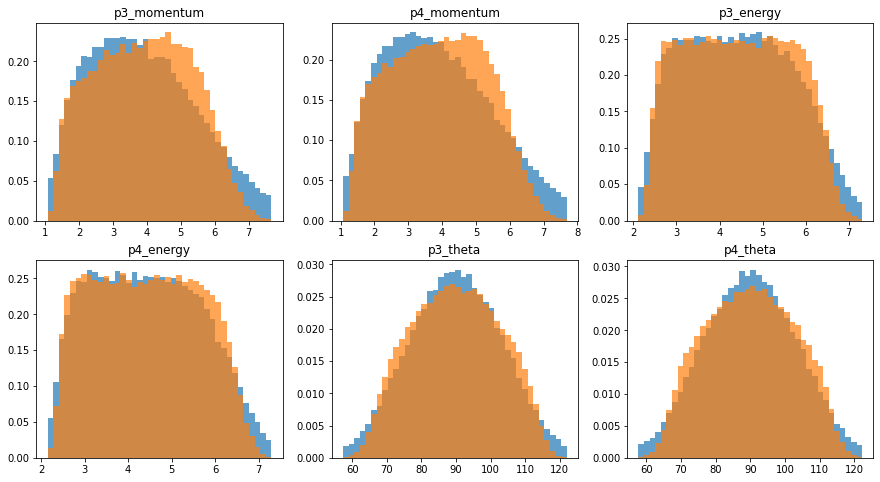

In [ ]:
#Plot an unweighted data set
original_weights = np.ones(len(allCollisions[0,0].index))

#Don't plot phi, it's not affected by any of the changes made to the data
columns=['p3_momentum','p4_momentum','p3_energy','p4_energy', 'p3_theta', 'p4_theta']
draw_distributions(allCollisions[0,0], allCollisions[0,1], original_weights)

print('Averaged KS values: ' + str(averageKS(original_test[1], target_test[1],np.ones(len(original_test[1])))))

#Naive Reweighter


KS over  p3_momentum  =  0.030439511722172186
KS over  p4_momentum  =  0.05109341083383445
KS over  p3_energy  =  0.023607424421501766
KS over  p4_energy  =  0.02387158793004973
KS over  p3_theta  =  0.021323185827064273
KS over  p4_theta  =  0.028634581518394552


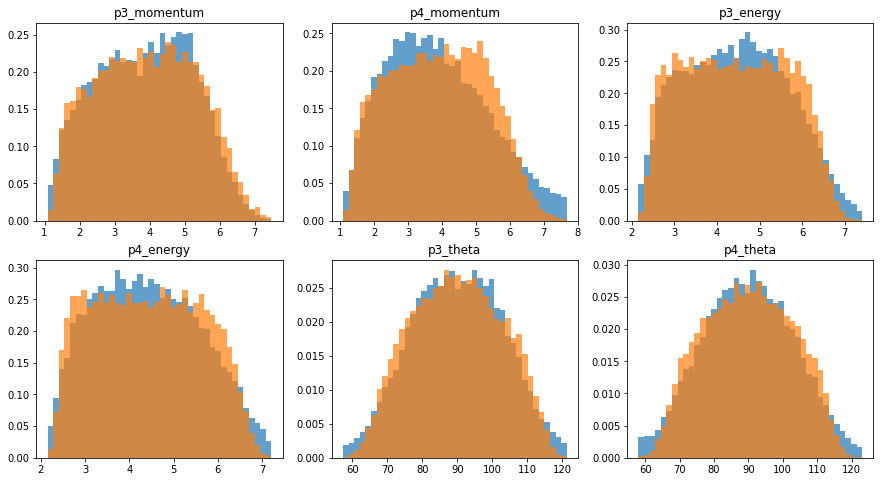

In [ ]:
#naive bin reweighter
#reweights only based on one variable (p3 momentum)
#Weight of each collision is entirely based off which bin it's p3 momentum falls into
reweight_bins = 50
bins_weights_test = np.empty(sets,dtype=object)
for i in range(sets):
  #Need bin edges for original set to apply weights to test data
  original_bins,bin_edges = np.histogram(original_train[i]['p3_momentum'], reweight_bins, density = False)
  target_bins = np.histogram(target_train[i]['p3_momentum'], density = False, bins = bin_edges)[0]

  #Add noise to prevent divisions by 0, counts are high enough that this has negligible effect
  original_bins = np.add(original_bins,1)
  target_bins = np.add(target_bins,1)

  #Convert histograms to probability density
  original_bins_normed = np.divide(original_bins, len(original_train[i].index))
  target_bins_normed = np.divide(target_bins, len(target_train[i].index))


  bin_weights = np.zeros(reweight_bins)

  #Calculate weights to match p3 momentum bins up (build model)
  for j in range(reweight_bins):
    bin_weights[j] = target_bins_normed[j] / original_bins_normed[j]

  #Apply the model to test data
  #find out what bin a point is in (use np.digitize here?)
  multi_factor = (reweight_bins-1) / max(original_test[i]['p3_momentum'])
  momentum_multi = original_test[i]['p3_momentum'] * multi_factor
  momentum_floored = momentum_multi.astype(int)
  #give a weight to each individual collision based on which bin it's in
  collision_weights = np.empty(len(momentum_floored))
  m = 0 
  for k in momentum_floored:
    collision_weights[m] = bin_weights[k]
    m += 1

  bins_weights_test[i] = collision_weights
    
#draw the histograms
draw_distributions(original_test[0], target_test[0], bins_weights_test[0])



# Neural Network Reweighters

In [ ]:
#Use MLP classifier to see if data is from the real set or the generated set

testCollisions = np.empty(sets,dtype=object)
trainCollisions = np.empty(sets,dtype=object)
trainLabels = np.empty(sets,dtype=object)
testLabels = np.empty(sets,dtype=object)

baseProba = np.empty(sets,dtype=object)
lbfgsProba = np.empty(sets,dtype=object)
adaProba = np.empty(sets,dtype=object)
sgdProba = np.empty(sets,dtype=object)


startTime = time.time()
for i in range(sets):

  #Join real and generated data togehter
  trainCollisions[i] = pd.concat([original_train[i],target_train[i]],ignore_index=True)

  testCollisions[i] = pd.concat([original_test[i],target_test[i]],ignore_index=True)


  #label is 1 for real data, 0 for random data 
  trainLabels[i] = np.concatenate((np.zeros(len(original_train[i].index)),np.ones(len(target_train[i].index))))
  testLabels[i] = np.concatenate((np.zeros(len(original_test[i].index)),np.ones(len(target_test[i].index))))

  #Uses adam solver by default, deep nn
  base_network = MLPClassifier(max_iter=1000,hidden_layer_sizes=(24,18,12,6)) #layers=[7, 7],loss='log_loss', trainer='irprop-', epochs=1000
  base_network.fit(trainCollisions[i], trainLabels[i])

  #Stores the probability that a collision belongs to the generated set in column 0 and to the real set in column 1
  baseProba[i] = base_network.predict_proba(original_test[i])

endTime = time.time()

print("Base Network Execution Time: " + str(endTime - startTime))

#A different weight optimisation solver
startTime = time.time()
for j in range(sets):


  lbfgs_network = MLPClassifier(max_iter=1000,solver='lbfgs',hidden_layer_sizes=(24,18,12,6)) #try solver sgd here?
  lbfgs_network.fit(trainCollisions[j], trainLabels[j])

  lbfgsProba[j] = lbfgs_network.predict_proba(original_test[j])


endTime = time.time()
print("lbfgs Network Execution Time: " + str(endTime - startTime))


#Shallow adam solver
startTime = time.time()
for j in range(sets):
  sgd_network = MLPClassifier(max_iter=1000,hidden_layer_sizes=(8,8)) 
  sgd_network.fit(trainCollisions[j], trainLabels[j])

  sgdProba[j] = sgd_network.predict_proba(original_test[j])


endTime = time.time()
print("SGD Network Execution Time: " + str(endTime - startTime))




Base Network Execution Time: 761.2465088367462


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

lbfgs Network Execution Time: 1542.2231893539429
SGD Network Execution Time: 566.2734496593475


# Ada Boost Reweighter

In [ ]:
#Different type of classifier
startTime = time.time()
for k in range(sets):

  adaClassifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

  adaClassifier.fit(trainCollisions[k], trainLabels[k])

  adaProba[k] = adaClassifier.predict_proba(original_test[k])

endTime = time.time()
print("Ada Classifier Execution Time: " + str(endTime - startTime))

Ada Classifier Execution Time: 30.11054825782776


In [ ]:
#Calculate weights here

weightBase = np.zeros(sets,dtype=object)
weightLbfgs = np.zeros(sets,dtype=object)
weightAda = np.zeros(sets,dtype=object)
weightSgd = np.zeros(sets,dtype=object)



#Calculate weights from neural network probabilities
for i in range(sets):

  weightBase[i] = probabilityToWeight(baseProba[i][:,1])
  weightLbfgs[i] = probabilityToWeight(lbfgsProba[i][:,1])
  weightAda[i] = probabilityToWeightAda(adaProba[i][:,1])
  weightSgd[i] = probabilityToWeight(sgdProba[i][:,1])
  




# Gradient Boosting Reweighter

KS over  p3_momentum  =  0.013114303381804193
KS over  p4_momentum  =  0.011864998552122308
KS over  p3_energy  =  0.01457782370888544
KS over  p4_energy  =  0.013183784036722768
KS over  p3_theta  =  0.01289299984003367
KS over  p4_theta  =  0.010961115200898153


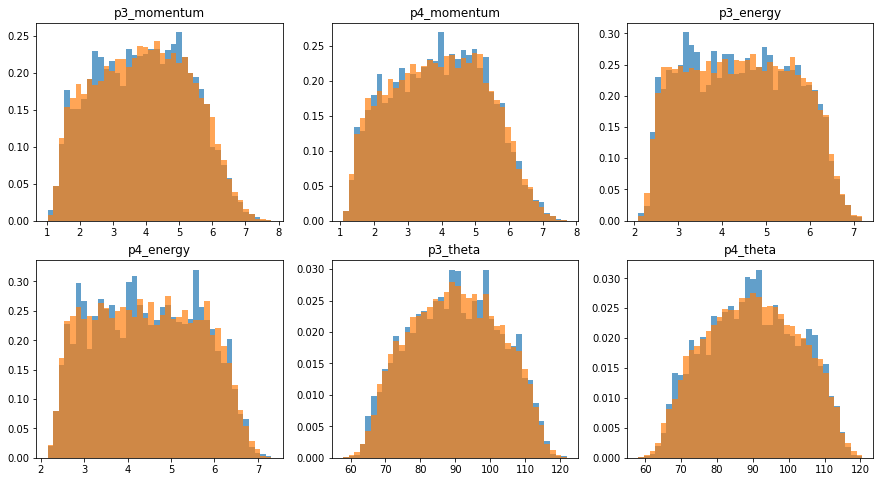

In [ ]:
#Gradient boosted reweighter
gb_weights_test = np.empty(sets,dtype=object)

for i in range(sets):

  #Can mess with these paramaters to optimse performance
  gb_reweighter = reweight.GBReweighter(n_estimators=100, 
                                        learning_rate=0.1, max_depth=32, min_samples_leaf=500, 
                                        gb_args={'subsample': 0.4, 'max_features' : 6, 'min_samples_split' : 201})
  gb_reweighter.fit(original_train[i], target_train[i])

  gb_weights_test[i] = gb_reweighter.predict_weights(original_test[i])

#Check weighted distributions on the test splits
draw_distributions(original_test[1], target_test[1], gb_weights_test[1])


KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KS over  p3_momentum  =  0.003164763237457846
KS over  p4_momentum  =  0.002669111097023835
KS over  p3_energy  =  0.003500179836663203
KS over  p4_energy  =  0.003431673100844468
KS over  p3_theta  =  0.00582885938912403
KS over  p4_theta  =  0.005974477394330935


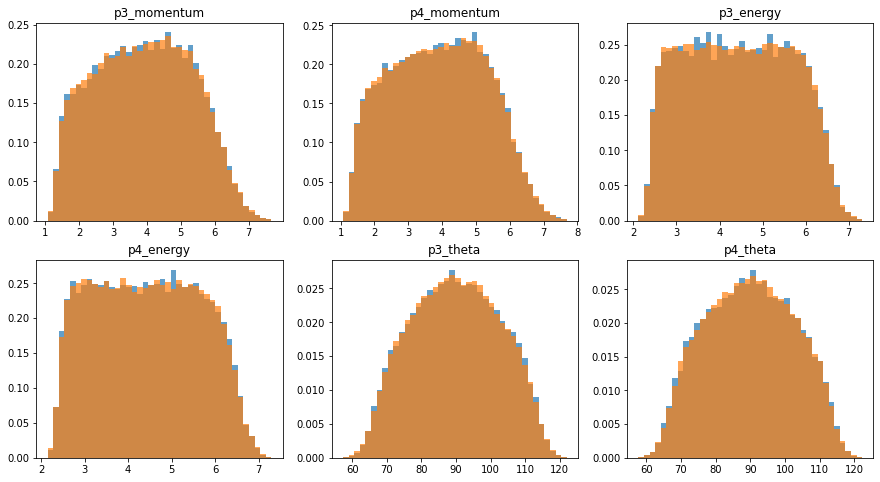

In [ ]:
#Folding Reweighter
folding_weights = np.empty(sets,dtype=object)

for i in range(sets):
  #Gradient boosted decision tree as base
  reweighter_gb = reweight.GBReweighter(  learning_rate=0.1, n_estimators=64, max_depth=32, min_samples_leaf=200, 
                                        gb_args={'subsample': 0.4,})
  folding_gb = reweight.FoldingReweighter(reweighter_gb, n_folds=5)
  
  #Give full datasets to the reweighter
  folding_gb.fit(allCollisions[i,0].drop(['p3','p4','p3_phi','p4_phi'], axis=1).to_numpy().tolist(), allCollisions[i,1].drop(['p3','p4','p3_phi','p4_phi'], axis=1).to_numpy().tolist())


  #folding_weights[i] = folding_reweighter.predict_weights(allCollisions[i,0].drop(['p3','p4','p3_phi','p4_phi'], axis=1).to_numpy().tolist(),vote_function = lambda x: np.mean(x, axis=0))

  #calculate weights for each point
  folding_weights[i] = folding_gb.predict_weights(allCollisions[i,0].drop(['p3','p4','p3_phi','p4_phi'], axis=1).to_numpy().tolist())



draw_distributions(allCollisions[0,0], allCollisions[0,1], folding_weights[0])


# Model Evaluation

In [ ]:
#Find KS values for reweighted data, calculate KS for each variable then average over this

noWeightTotal = np.zeros(sets)
binTotal = np.zeros(sets)
gbTotal = np.zeros(sets)
foldingTotal = np.zeros(sets)
nnTotal = np.zeros(sets)
adaTotal = np.zeros(sets)
lbfgsTotal = np.zeros(sets)
sgdTotal = np.zeros(sets)

for i in range(sets):

  noWeightTotal[i] += averageKS(original_test[i], target_test[i],np.ones(len(original_test[i])))

  binTotal[i] += averageKS(original_test[i], target_test[i],bins_weights_test[i])
  gbTotal[i] += averageKS(original_test[i], target_test[i],gb_weights_test[i])
  foldingTotal[i] += averageKS(allCollisions[i,0].drop(['p3','p4','p3_phi','p4_phi'], axis=1), allCollisions[i,1].drop(['p3','p4','p3_phi','p4_phi'], axis=1), folding_weights[i])

  nnTotal[i] += averageKS(original_test[i], target_test[i],weightBase[i])
  lbfgsTotal[i] += averageKS(original_test[i], target_test[i],weightLbfgs[i])
  adaTotal[i] += averageKS(original_test[i], target_test[i],weightAda[i])
  sgdTotal[i] += averageKS(original_test[i], target_test[i],weightSgd[i])


Text(0.5, 0, 'Reweighting Method')

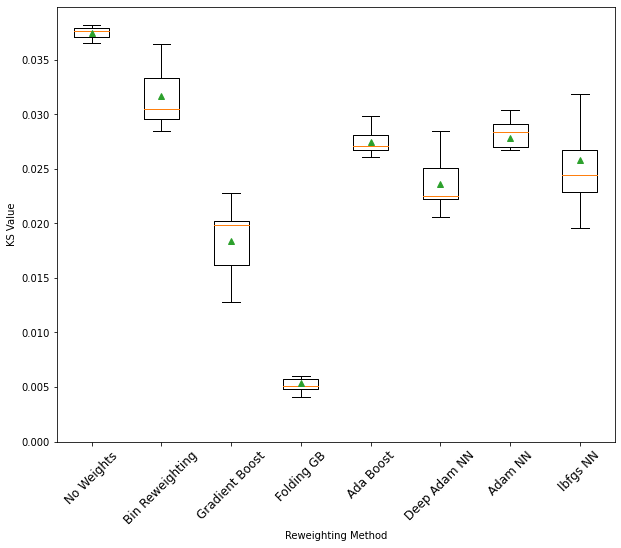

In [ ]:
fig, ax = plt.subplots()
bp = ax.boxplot([noWeightTotal, binTotal, gbTotal, foldingTotal, adaTotal, nnTotal, sgdTotal, lbfgsTotal],notch=False,sym='',showmeans=1)
ax.set_ylim(bottom=0)
ax.set_xticklabels(['No Weights','Bin Reweighting','Gradient Boost','Folding GB','Ada Boost','Deep Adam NN','Adam NN','lbfgs NN'],rotation=45, fontsize=12)
ax.set_ylabel('KS Value')
ax.set_xlabel('Reweighting Method')

In [ ]:
#Number of bins to calculate kl divergence over
kl_bins = 40

noWeightTotal_KL = np.zeros(sets)
binTotal_KL = np.zeros(sets)
gbTotal_KL = np.zeros(sets)
foldingTotal_KL = np.zeros(sets)
nnTotal_KL = np.zeros(sets)
adaTotal_KL = np.zeros(sets)
lbfgsTotal_KL = np.zeros(sets)
sgdTotal_KL = np.zeros(sets)

noWeight_kl = np.zeros(sets)
bin_kl = np.zeros(sets)
gb_kl = np.zeros(sets)
folding_kl = np.zeros(sets)
nn_kl = np.zeros(sets)
ada_kl = np.zeros(sets)
lbfgs_kl = np.zeros(sets)
sgd_kl = np.zeros(sets)

#Store ranges in a dict
ranges = {"p3_momentum" : (1,8), "p4_momentum" : (1,8), "p3_energy" : (1,8),"p4_energy" : (1,8), "p3_theta" : (1,2.2), "p4_theta" : (1,2.2)}

#Create lists of dicts to hold the histograms for each dimension of each data set
target_density_hists = [dict(p3_momentum = np.zeros(kl_bins), p4_momentum = np.zeros(kl_bins), p3_energy = np.zeros(kl_bins), p4_energy = np.zeros(kl_bins), p3_theta = np.zeros(kl_bins), p4_theta = np.zeros(kl_bins)) for x in range(sets)]
noWeight_density_hists = [dict(p3_momentum = np.zeros(kl_bins), p4_momentum = np.zeros(kl_bins), p3_energy = np.zeros(kl_bins), p4_energy = np.zeros(kl_bins), p3_theta = np.zeros(kl_bins), p4_theta = np.zeros(kl_bins)) for x in range(sets)]
bin_density_hists = [dict(p3_momentum = np.zeros(kl_bins), p4_momentum = np.zeros(kl_bins), p3_energy = np.zeros(kl_bins), p4_energy = np.zeros(kl_bins), p3_theta = np.zeros(kl_bins), p4_theta = np.zeros(kl_bins)) for x in range(sets)]
gb_density_hists = [dict(p3_momentum = np.zeros(kl_bins), p4_momentum = np.zeros(kl_bins), p3_energy = np.zeros(kl_bins), p4_energy = np.zeros(kl_bins), p3_theta = np.zeros(kl_bins), p4_theta = np.zeros(kl_bins)) for x in range(sets)]
folding_density_hists = [dict(p3_momentum = np.zeros(kl_bins), p4_momentum = np.zeros(kl_bins), p3_energy = np.zeros(kl_bins), p4_energy = np.zeros(kl_bins), p3_theta = np.zeros(kl_bins), p4_theta = np.zeros(kl_bins)) for x in range(sets)]
nn_density_hists = [dict(p3_momentum = np.zeros(kl_bins), p4_momentum = np.zeros(kl_bins), p3_energy = np.zeros(kl_bins), p4_energy = np.zeros(kl_bins), p3_theta = np.zeros(kl_bins), p4_theta = np.zeros(kl_bins)) for x in range(sets)]
ada_density_hists = [dict(p3_momentum = np.zeros(kl_bins), p4_momentum = np.zeros(kl_bins), p3_energy = np.zeros(kl_bins), p4_energy = np.zeros(kl_bins), p3_theta = np.zeros(kl_bins), p4_theta = np.zeros(kl_bins)) for x in range(sets)]
lbfgs_density_hists = [dict(p3_momentum = np.zeros(kl_bins), p4_momentum = np.zeros(kl_bins), p3_energy = np.zeros(kl_bins), p4_energy = np.zeros(kl_bins), p3_theta = np.zeros(kl_bins), p4_theta = np.zeros(kl_bins)) for x in range(sets)]
sgd_density_hists = [dict(p3_momentum = np.zeros(kl_bins), p4_momentum = np.zeros(kl_bins), p3_energy = np.zeros(kl_bins), p4_energy = np.zeros(kl_bins), p3_theta = np.zeros(kl_bins), p4_theta = np.zeros(kl_bins)) for x in range(sets)]

#Calculate normalised histograms for each dimension in each data set
for i in range(sets):

  original_test_set = original_test[i]
  target_test_set = target_test[i]

  for column in original_test[i].columns:
    target_density_hists[i][column] = np.histogram(target_test_set[column],density=0,bins=kl_bins,range=ranges[column])[0]
    noWeight_density_hists[i][column] = np.histogram(original_test_set[column],density=0,bins=kl_bins,range=ranges[column])[0]
    bin_density_hists[i][column] = np.histogram(original_test_set[column],weights=bins_weights_test[i],density=0,bins=kl_bins,range=ranges[column])[0]
    gb_density_hists[i][column] = np.histogram(original_test_set[column],weights=gb_weights_test[i],density=0,bins=kl_bins,range=ranges[column])[0]
    folding_density_hists[i][column] = np.histogram(allCollisions[i,0].drop(['p3','p4','p3_phi','p4_phi'], axis=1)[column],weights=folding_weights[i],density=0,bins=kl_bins,range=ranges[column])[0]
    nn_density_hists[i][column] = np.histogram(original_test_set[column],weights=weightBase[i],density=0,bins=kl_bins,range=ranges[column])[0]
    ada_density_hists[i][column] = np.histogram(original_test_set[column],weights=weightAda[i],density=0,bins=kl_bins,range=ranges[column])[0]
    lbfgs_density_hists[i][column] = np.histogram(original_test_set[column],weights=weightLbfgs[i],density=0,bins=kl_bins,range=ranges[column])[0]
    sgd_density_hists[i][column] = np.histogram(original_test_set[column],weights=weightSgd[i],density=0,bins=kl_bins,range=ranges[column])[0]


    #Make sure there are no bins with 0 counts
    #To prevent infinity errors when computing KL divergence, 1 count is small enough that it will hardly effect the overall outcome
    #Put this in a function?
    target_density_hists[i][column][target_density_hists[i][column] == 0] = 1
    noWeight_density_hists[i][column][noWeight_density_hists[i][column] == 0] = 1
    bin_density_hists[i][column][bin_density_hists[i][column] == 0] = 1
    gb_density_hists[i][column][gb_density_hists[i][column] == 0] = 1
    folding_density_hists[i][column][folding_density_hists[i][column] == 0] = 1
    nn_density_hists[i][column][nn_density_hists[i][column] == 0] = 1
    ada_density_hists[i][column][ada_density_hists[i][column] == 0] = 1
    lbfgs_density_hists[i][column][lbfgs_density_hists[i][column] == 0] = 1
    sgd_density_hists[i][column][sgd_density_hists[i][column] == 0] = 1

    #Write a normalisation function to neaten this up
    target_density_hists[i][column] = target_density_hists[i][column]/np.sum(target_density_hists[i][column])
    noWeight_density_hists[i][column] = noWeight_density_hists[i][column]/np.sum(noWeight_density_hists[i][column])
    bin_density_hists[i][column] = bin_density_hists[i][column]/np.sum(bin_density_hists[i][column])
    gb_density_hists[i][column] = gb_density_hists[i][column]/np.sum(gb_density_hists[i][column])
    folding_density_hists[i][column] = folding_density_hists[i][column]/np.sum(folding_density_hists[i][column])
    nn_density_hists[i][column] = nn_density_hists[i][column]/np.sum(nn_density_hists[i][column])
    ada_density_hists[i][column] = ada_density_hists[i][column]/np.sum(ada_density_hists[i][column])
    lbfgs_density_hists[i][column] = lbfgs_density_hists[i][column]/np.sum(lbfgs_density_hists[i][column])
    sgd_density_hists[i][column] = sgd_density_hists[i][column]/np.sum(sgd_density_hists[i][column])


    #Add up KL divergences from each dimension for each weighting method
    noWeightTotal_KL[i] += np.sum(rel_entr(target_density_hists[i][column],noWeight_density_hists[i][column]))
    binTotal_KL[i] += np.sum(rel_entr(target_density_hists[i][column],bin_density_hists[i][column]))
    gbTotal_KL[i] += np.sum(rel_entr(target_density_hists[i][column],gb_density_hists[i][column]))
    foldingTotal_KL[i] += np.sum(rel_entr(target_density_hists[i][column],folding_density_hists[i][column]))
    nnTotal_KL[i] += np.sum(rel_entr(target_density_hists[i][column],nn_density_hists[i][column]))
    adaTotal_KL[i] += np.sum(rel_entr(target_density_hists[i][column],ada_density_hists[i][column]))
    lbfgsTotal_KL[i] += np.sum(rel_entr(target_density_hists[i][column],lbfgs_density_hists[i][column]))
    sgdTotal_KL[i] += np.sum(rel_entr(target_density_hists[i][column],sgd_density_hists[i][column]))

  #Then average them for each data set
  #this is such a mess send help
  noWeight_kl[i] = noWeightTotal_KL[i] / len(columns)
  bin_kl[i] = binTotal_KL[i] / len(columns)
  gb_kl[i] = gbTotal_KL[i] / len(columns)
  folding_kl[i] = foldingTotal_KL[i] / len(columns)
  nn_kl[i] = nnTotal_KL[i] / len(columns)
  ada_kl[i] = adaTotal_KL[i] / len(columns)
  lbfgs_kl[i] = lbfgsTotal_KL[i] / len(columns)
  sgd_kl[i] = sgdTotal_KL[i] / len(columns)
    
    

Text(0.5, 0, 'Reweighting Method')

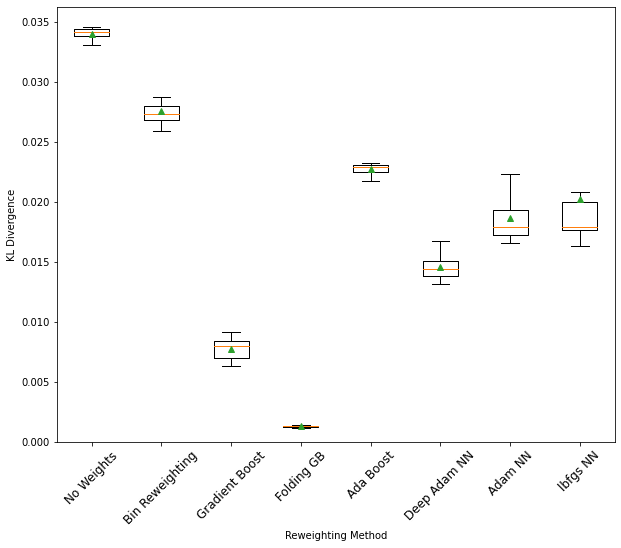

In [ ]:
fig, ax = plt.subplots()
bp = ax.boxplot([noWeight_kl,bin_kl,gb_kl,folding_kl,ada_kl,nn_kl,sgd_kl,lbfgs_kl],notch=False,sym='',showmeans=1)
ax.set_ylim(bottom=0)
ax.set_xticklabels(['No Weights','Bin Reweighting','Gradient Boost','Folding GB','Ada Boost','Deep Adam NN','Adam NN','lbfgs NN'],rotation=45, fontsize=12)
ax.set_ylabel('KL Divergence')
ax.set_xlabel('Reweighting Method')